In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import re
import datetime
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [34]:
df = pd.read_csv('./data/seoul-bike-data.csv', encoding='unicode_escape')
df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


At first glance, the data appears to be clean, most variables are well typed. We can also see that some columns have class values, which we'll need to encode later.

In [35]:
display(df.info())
display(df.describe().T)
display(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

None

,count,mean,std,min,25%,50%,75%,max
Rented Bike Count,8760.0,704.602055,644.997468,0.0,191.00,504.50,1065.25,3556.00
Hour,8760.0,11.500000,6.922582,0.0,5.75,11.50,17.25,23.00
Temperature(°C),8760.0,12.882922,11.944825,-17.8,3.50,13.70,22.50,39.40
Humidity(%),8760.0,58.226256,20.362413,0.0,42.00,57.00,74.00,98.00
Wind speed (m/s),8760.0,1.724909,1.036300,0.0,0.90,1.50,2.30,7.40
Visibility (10m),8760.0,1436.825799,608.298712,27.0,940.00,1698.00,2000.00,2000.00
Dew point temperature(°C),8760.0,4.073813,13.060369,-30.6,-4.70,5.10,14.80,27.20
Solar Radiation (MJ/m2),8760.0,0.569111,0.868746,0.0,0.00,0.01,0.93,3.52
Rainfall(mm),8760.0,0.148687,1.128193,0.0,0.00,0.00,0.00,35.00
Snowfall (cm),8760.0,0.075068,0.436746,0.0,0.00,0.00,0.00,8.80


Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64

Here we can see that we'll need to change the type of the "Date" column, as well as encode the "Season", "Holiday" and "Functional Day" columns.
We can also see that we'll need to normalize the values to ensure consistency in their interpretation.
Finally, there are no missing values

In [36]:
hourly_counts = df.groupby('Date')['Hour'].nunique()
dates_with_incomplete_hours = hourly_counts[hourly_counts != 24]
print("Number of dates with incomplete hourly data:", len(dates_with_incomplete_hours))

Number of dates with incomplete hourly data: 0


So we have verified that for every date in the dataset, we have 24 different hourly records. This is important because we'll be using the date and hour columns to index the dataset.

In [37]:
min_date = df['Date'].min()
max_date = df['Date'].max()
all_dates = pd.date_range(start=min_date, end=max_date, freq='D')
df['Date'] = pd.to_datetime(df['Date'])
missing_dates = all_dates.difference(df['Date'])
print(f"There are {len(missing_dates)} missing dates in the range")

There are 0 missing dates in the range


c:\Users\hugoz\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: UserWarning: Parsing '31/12/2017' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\hugoz\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '13/12/2017' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
c:\Users\hugoz\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '14/12/2017' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
c:\Users\hugoz\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '15/12/2017' in DD/MM/YYYY format. Provide format or specify infer_datet

We know now that there are no missing dates in the range, so we can proceed to index the dataset by date and hour.

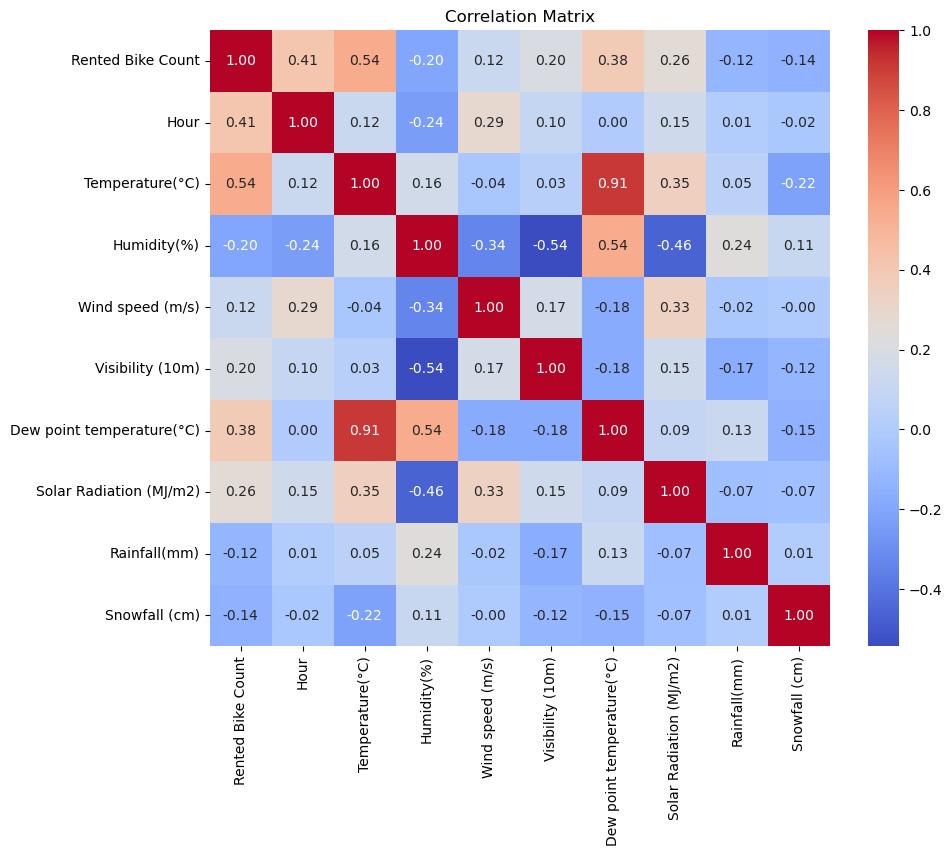

In [38]:
# Select only numerical columns for correlation matrix
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


Thanks to this correlation matrix, we can see that there is a strong correlation between the temperature and the dew point temperature, which is to be expected. Thus we can delete the dew point temperature column.

In [39]:
df = df.drop(columns=['Dew point temperature(°C)'])

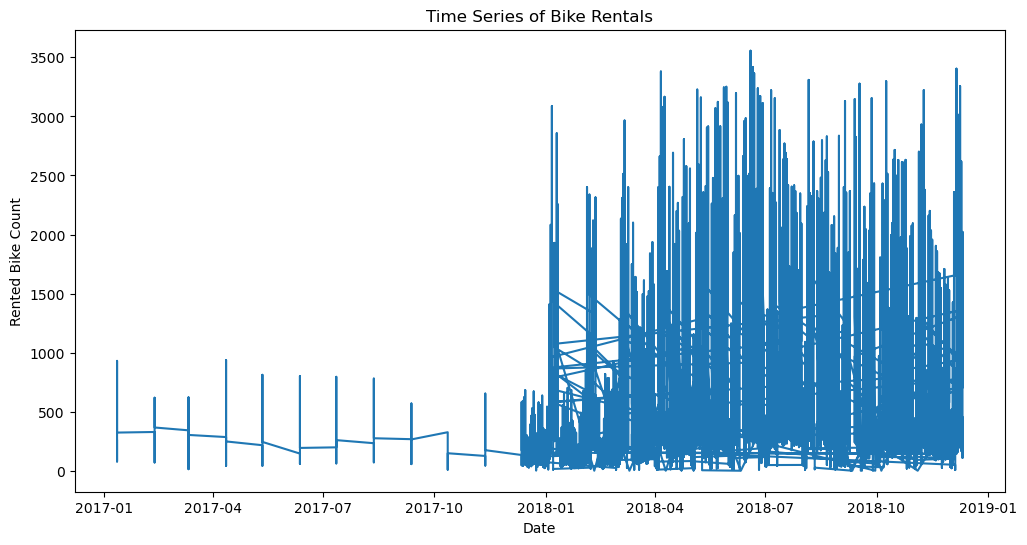

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Rented Bike Count'])
plt.title('Time Series of Bike Rentals')
plt.xlabel('Date')
plt.ylabel('Rented Bike Count')
plt.show()

In [41]:
encoder = OneHotEncoder(sparse=False)
seasons_encoded = encoder.fit_transform(df[['Seasons']])

# Convert to DataFrame and add appropriate column names
seasons_encoded_df = pd.DataFrame(seasons_encoded, columns=encoder.get_feature_names_out(['Seasons']))

# Map 'Holiday' to 1 and 'No Holiday' to 0
df['Holiday'] = df['Holiday'].map({'Holiday': 1, 'No Holiday': 0})
df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
df = pd.concat([df, seasons_encoded_df], axis=1)

In [42]:
from sklearn.preprocessing import StandardScaler

numerical_cols = ['Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']

scaler = StandardScaler()
#df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [43]:
df = df.set_index(['Date', 'Holiday', 'Functioning Day', 'Seasons_Autumn', 'Seasons_Spring', 'Seasons_Summer', 'Seasons_Winter', 'Hour'])
df.head()

Rented Bike Count  \
Date       Holiday Functioning Day Seasons_Autumn Seasons_Spring Seasons_Summer Seasons_Winter Hour                      
2017-01-12 0       1               0.0            0.0            0.0            1.0            0                   254   
                                                                                               1                   204   
                                                                                               2                   173   
                                                                                               3                   107   
                                                                                               4                    78   

                                                                                                     Temperature(°C)  \
Date       Holiday Functioning Day Seasons_Autumn Seasons_Spring Seasons_Summer Seasons_Winter Hour                    
2017-01-12 0       1               0.0            0.0            0.0            1.0            0                -5.2   
                                                                                               1                -5.5   
                                                                                               2                -6.0   
                                                                                               3                -6.2   
                                                                                               4                -6.0   

                                                                                                     Humidity(%)  \
Date       Holiday Functioning Day Seasons_Autumn Seasons_Spring Seasons_Summer Seasons_Winter Hour                
2017-01-12 0       1               0.0            0.0            0.0            1.0            0              37   
                                                                                               1              38   
                                                                                               2              39   
                                                                                               3              40   
                                                                                               4              36   

                                                                                                     Wind speed (m/s)  \
Date       Holiday Functioning Day Seasons_Autumn Seasons_Spring Seasons_Summer Seasons_Winter Hour                     
2017-01-12 0       1               0.0            0.0            0.0            1.0            0                  2.2   
                                                                                               1                  0.8   
                                                                                               2                  1.0   
                                                                                               3                  0.9   
                                                                                               4                  2.3   

                                                                                                     Visibility (10m)  \
Date       Holiday Functioning Day Seasons_Autumn Seasons_Spring Seasons_Summer Seasons_Winter Hour                     
2017-01-12 0       1               0.0            0.0            0.0            1.0            0                 2000   
                                                                                               1                 2000   
                                                                                               2                 2000   
                                                                                               3                 2000   
                  

In [44]:
df.to_csv('./data/seoul-bike-data-clean.csv')